<figure>
  <IMG SRC="Logo.png"  WIDTH=150 ALIGN="right">
</figure>

## Projections of mean sea level and tides<br>
### Six Dutch stations
<b>Prepared by: H.G. Voortman</b>


<figure>
    <IMG SRC="https://www.python.org/static/community_logos/python-powered-w-200x80.png"  WIDTH=100 ALIGN="right">
</figure>

#### Description
- Showing examples of effects in the North Sea

#### References
- Provided in report

#### Packages

In [18]:
# General packages
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3 as sq
import numpy as np
#import scipy.signal as signal
#import datetime as dt
import hvec_stat.general_fit as gf
#import hvec_stat.gof as gof
import hvec_stat.support as sup
import models as mdl

In [19]:
# Settings
plt.rcParams['axes.grid'] = True
figsize = (20, 18)

#### Connect databases and import data

##### Processed data Rijkswaterstaat

In [20]:
# Connect database
conn_str = os.getenv('DATAPATH') + 'RWS_processed.db'
cnxn = sq.connect(conn_str, detect_types = True)

In [21]:
pd.read_sql('SELECT * FROM sqlite_master', cnxn)

,type,name,tbl_name,rootpage,sql
0,table,const_yr,const_yr,2,"CREATE TABLE ""const_yr"" (\n""naam"" TEXT,\n ""le..."
1,index,ix_const_yr_naam_level_1,const_yr,3,"CREATE INDEX ""ix_const_yr_naam_level_1""ON ""con..."


In [22]:
# Read table with observed water levels; complete years only
sql = (
    "SELECT * "
    "FROM 'const_yr' "
    "WHERE naam IN ('Delfzijl', 'Harlingen', "
    "'Den Helder', 'IJmuiden',  "
    "'Hoek van Holland', 'Vlissingen') "
    "AND (count>650) "
#    "AND (set == 'Ftested3') "
)
df = pd.read_sql(sql, cnxn) #.groupby('YEAR').mean()

In [23]:
cnxn.close()

In [24]:
df.columns = df.columns.str.replace('_ampl', '')
df.columns

Index(['naam', 'level_1', 'z0', 'zmean', 'count', 'M2', 'S2', 'Rsq_adj',
       'MHWS', 'MLWS', 'MHWN', 'MLWN', 'year', 'year_start', 'set', 'M4', 'O1',
       'K2', 'K1', 'P1', 'N2', 'M6', 'MU2', 'L2', '2MS6', 'MS4', 'NU2', 'SA'],
      dtype='object')

In [25]:
#df = df[np.abs(df['z0']) < 1e2]
#df = df[np.abs(df['M2']) < 1e2]
df = df[df['year'].between(1945, 2005)]

In [26]:
names = [
#    'Delfzijl',
    'Harlingen',
    'Den Helder',
    'IJmuiden',
    'Hoek van Holland',
    'Vlissingen'
]

In [27]:
df = df[df['set'] == 'Ftested3']

#### Show graphs

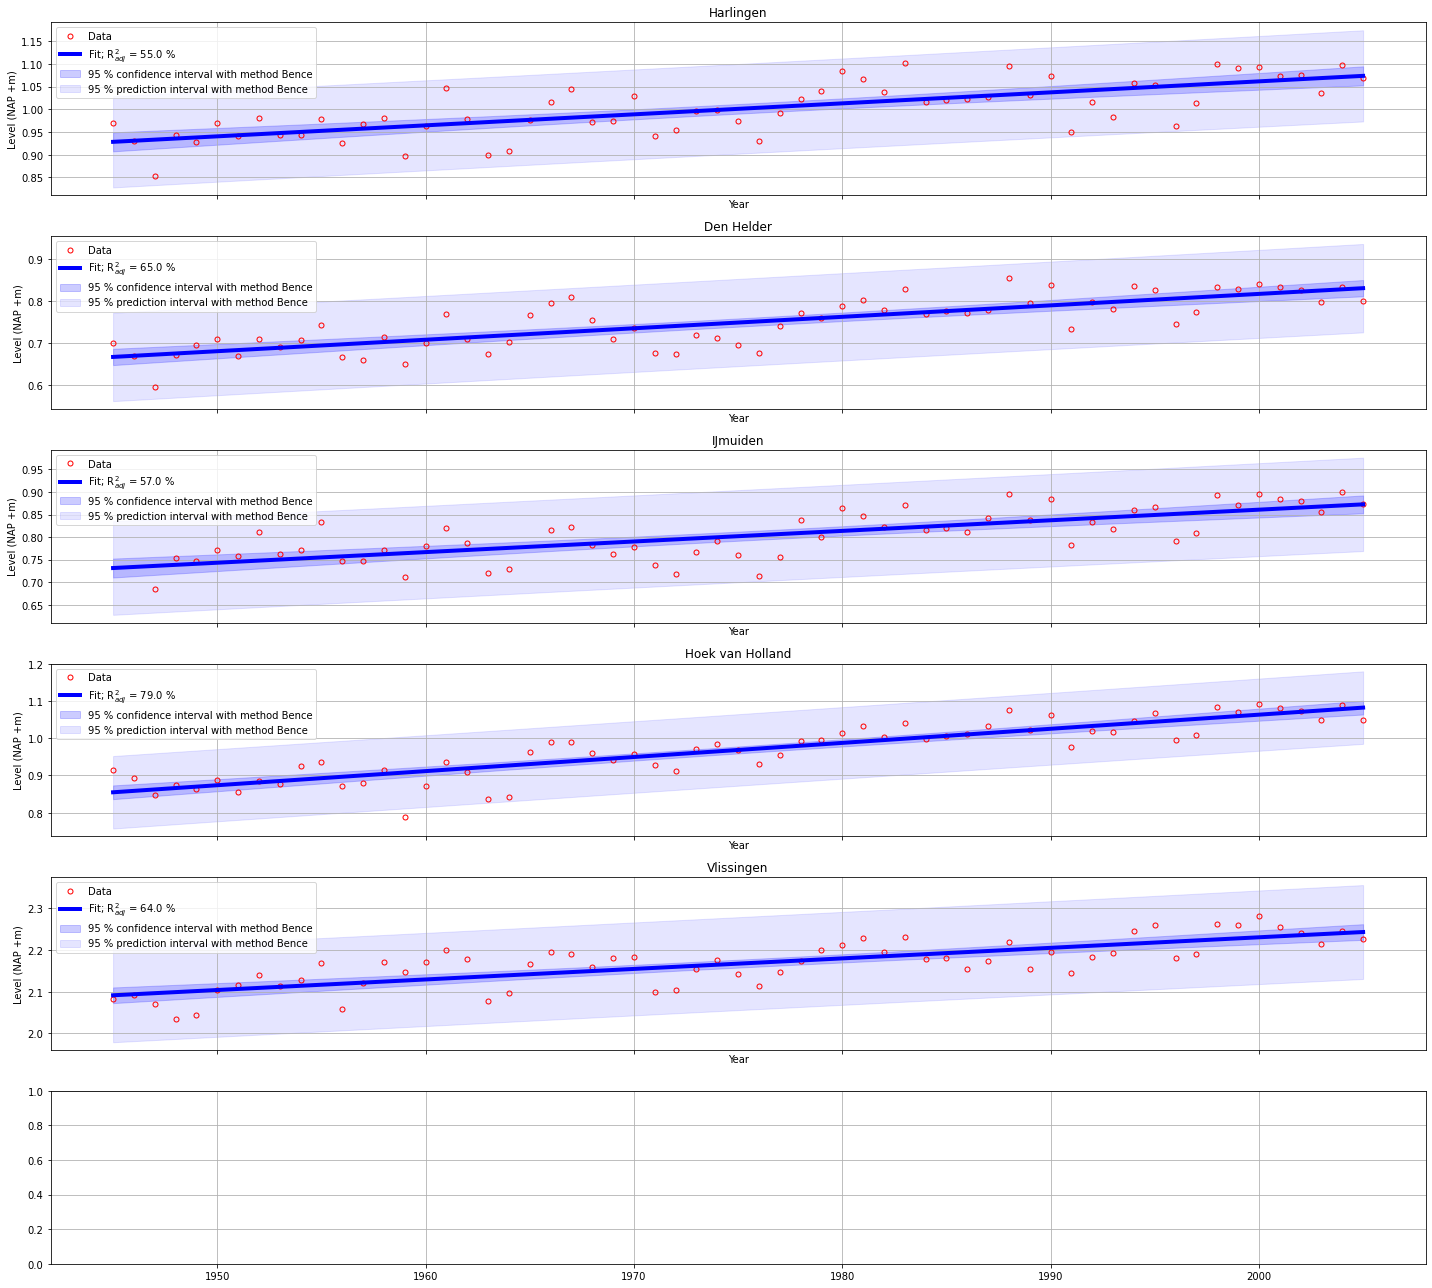

In [28]:
xgr = np.linspace(min(df['year']), 2005, 1000)

fig, ax = plt.subplots(nrows = 6, ncols = 1, sharex = True, sharey = False, figsize = figsize)

for i, nm in enumerate(names):
    data = df[df['naam'] == nm]
    plt.subplot(6,1,i+1)
    gf.plot_general_fit(
        mdl.model1, xgr, data['year'], data['MHWS'],
        pred_int = True,
        xlabel = 'Year', ylabel = 'Level (NAP +m)',
        title = nm, size = (13,5), method = 'Bence'
    )
    plt.savefig(r'../pics/MHWS_model1.jpg')
    

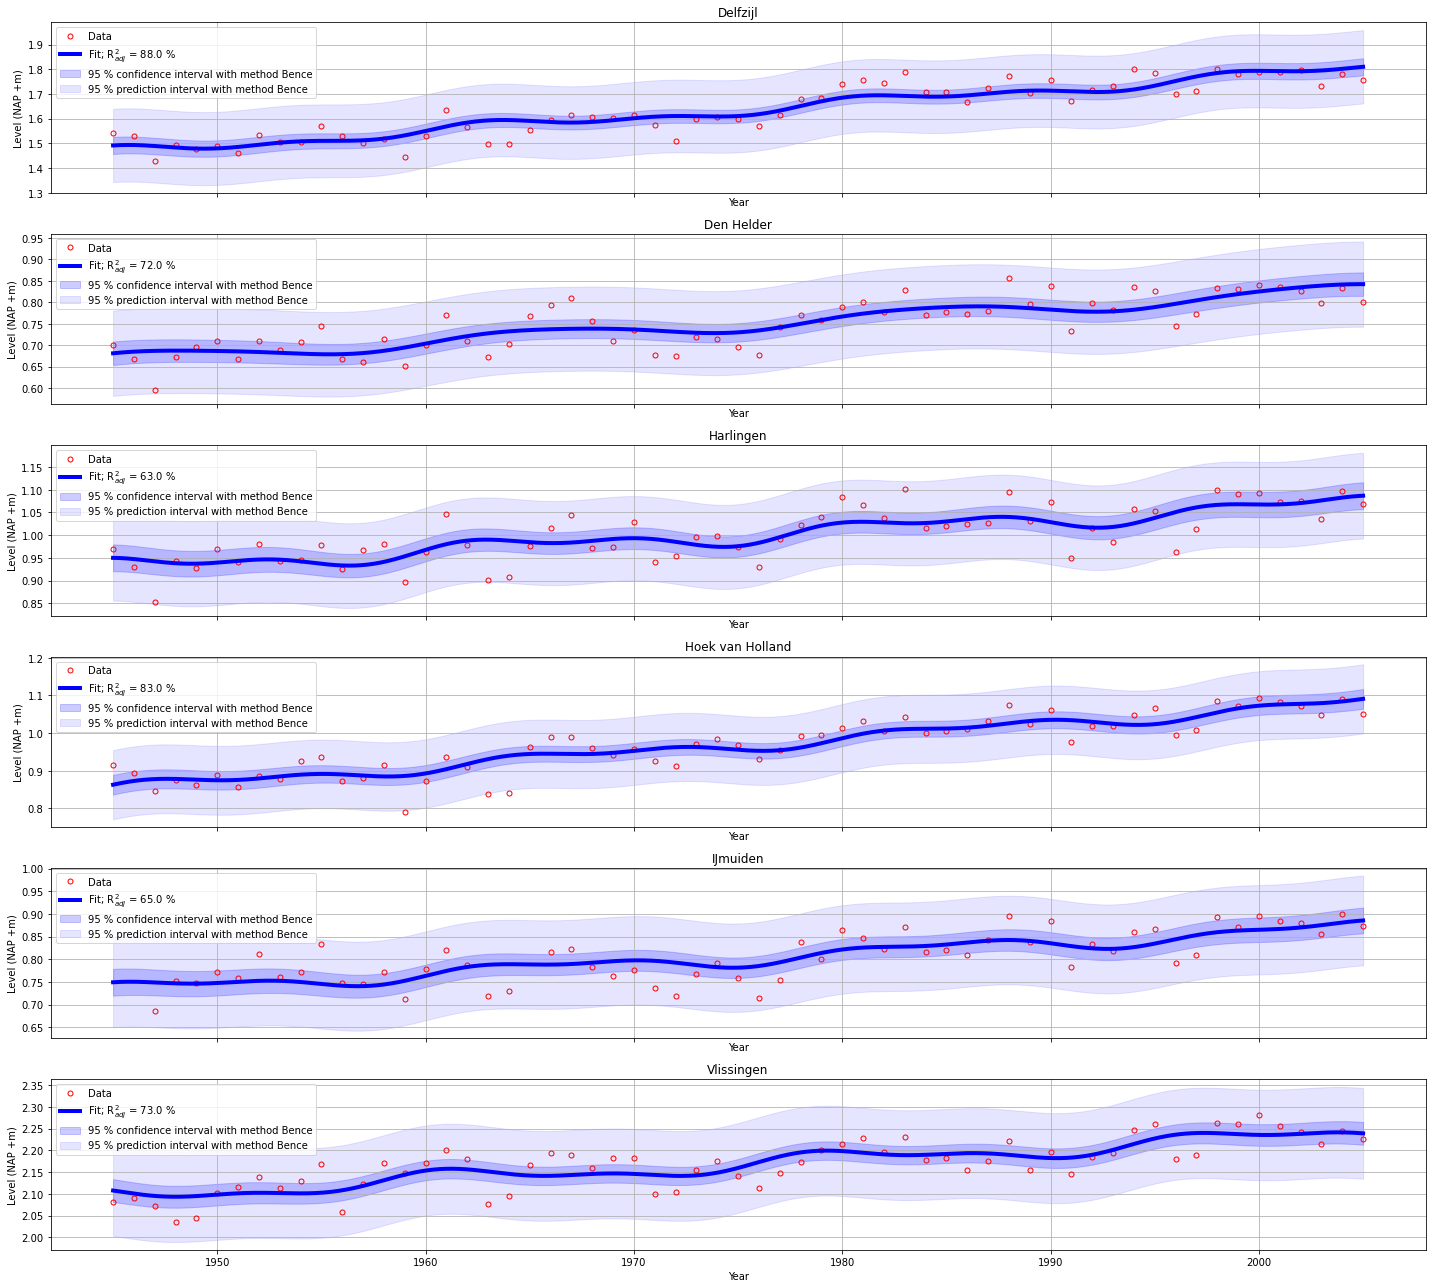

In [29]:
#xgr = np.linspace(1945, 2150, 1000)

fig, ax = plt.subplots(nrows = 6, ncols = 1, sharex = True, sharey = False, figsize = figsize)

for i, nm in enumerate(df['naam'].unique()):
    data = df[df['naam'] == nm]
    plt.subplot(6,1,i+1)
    gf.plot_general_fit(
        mdl.model3, xgr, data['year'], data['MHWS'],
        pred_int = True,
        xlabel = 'Year', ylabel = 'Level (NAP +m)',
        title = nm, size = (13,5), method = 'Bence'
    )
plt.savefig(r'../pics/MHWS_model3c.jpg')
    

#### Testing models
- R_{sq}^{adj}

In [30]:
model_list = [
    mdl.model1,
    mdl.model2,
    mdl.model3,
    mdl.model4,
#    mdl.model5
]

In [31]:
df_Rsq = pd.DataFrame()

for model in model_list:
    tmp = df.groupby('naam').apply(
        lambda df: gf.fit_with_uncert(
            model,
            x = df['year'],
            y = df['MHWS'],
            method = 'Bence'
            )[5]
        )

    tmp = pd.DataFrame(data = tmp, columns = [model.__name__])
    tmp = np.round(tmp, 3)
    df_Rsq = pd.concat([df_Rsq, tmp], axis = 1)

df_Rsq

,model1,model2,model3,model4
naam,,,,
Delfzijl,0.841,0.849,0.883,0.892
Den Helder,0.650,0.663,0.723,0.736
Harlingen,0.550,0.562,0.631,0.643
Hoek van Holland,0.794,0.801,0.834,0.840
IJmuiden,0.569,0.599,0.652,0.668
Vlissingen,0.640,0.657,0.731,0.748


In [32]:
df_Rsq.to_excel(r'../results/Rsq_MHWS.xlsx')

In [33]:
df_Fclassic = pd.DataFrame()

for model in model_list:
    tmp = df.groupby('naam').apply(
        lambda df: sup.Ftest_classic_direct(
            model,
            xdata = df['year'],
            ydata = df['MHWS'],
            method = 'Bence'
            )['p'] * 100
        )

    tmp = pd.DataFrame(data = tmp, columns = [model.__name__])
    tmp = np.round(tmp, 1)
    df_Fclassic = pd.concat([df_Fclassic, tmp], axis = 1)

df_Fclassic

,model1,model2,model3,model4
naam,,,,
Delfzijl,0.0,0.0,0.0,0.0
Den Helder,0.0,0.0,0.0,0.0
Harlingen,0.0,0.0,0.0,0.0
Hoek van Holland,0.0,0.0,0.0,0.0
IJmuiden,0.0,0.0,0.0,0.0
Vlissingen,0.0,0.0,0.0,0.0


In [34]:
df_Fcomp1 = pd.DataFrame()

for model in model_list[1:]:
    tmp = df.groupby('naam').apply(
        lambda df: sup.Ftest_reduced_direct(
            f_full = model, f_red = mdl.model1,
            xdata = df['year'],
            ydata = df['MHWS'],
            method = 'Bence'
            )['p'] * 100
        )

    tmp = pd.DataFrame(data = tmp, columns = [model.__name__])
    tmp = np.round(tmp, 1)
    df_Fcomp1 = pd.concat([df_Fcomp1, tmp], axis = 1)

df_Fcomp1

,model2,model3,model4
naam,,,
Delfzijl,95.4,63.9,75.6
Den Helder,99.7,47.9,58.0
Harlingen,92.2,32.1,40.2
Hoek van Holland,82.8,48.3,63.0
IJmuiden,20.8,59.0,50.3
Vlissingen,77.3,45.7,58.2


#### End script
Prepared by HVEC lab, 2022